In [64]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    classification_report, roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from scipy import stats



%matplotlib inline

# Modeling imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics ,linear_model, neighbors, ensemble , tree 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold ,RandomizedSearchCV
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, fbeta_score, roc_auc_score,precision_recall_curve , roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier, RandomForestRegressor , ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')



os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [45]:
# Define the data types as a dictionary
dtypes = {
    'census_tract': 'float32',
    'action_taken': 'int32',
    'loan_type': 'int32',
    'lien_status': 'int32',
    'reverse_mortgage': 'int32',
    'open_end_line_of_credit': 'int32',
    'loan_amount': 'int32',
    'combined_loan_to_value_ratio': 'int32',
    'interest_rate': 'float32',
    'total_loan_costs': 'int32',
    'origination_charges': 'int32',
    'loan_term': 'int32',
    'negative_amortization': 'int32',
    'interest_only_payment': 'int32',
    'balloon_payment': 'int32',
    'other_nonamortizing_features': 'int32',
    'property_value': 'float32',
    'occupancy_type': 'int32',
    'manufactured_home_secured_property_type': 'int32',
    'manufactured_home_land_property_interest': 'int32',
    'total_units': 'int32',
    'income': 'float32',
    'debt_to_income_ratio': 'int32',
    'applicant_credit_score_type': 'int32',
    'co_applicant_credit_score_type': 'int32',
    'applicant_sex': 'int32',
    'co_applicant_sex': 'int32',
    'applicant_age': 'int32',
    'co_applicant_age': 'int32',
    'aus_1': 'int32',
    'applicant_race_1': 'float32',
    'applicant_race_2': 'float32',
    'co_applicant_race_1': 'float32',
    'co_applicant_race_2': 'float32',
    'applicant_ethnicity_1': 'float32',
    'co_applicant_ethnicity_1': 'float32'
}

In [46]:
# Read the CSV file with specified data types
df = pd.read_csv('10_all_numerical_32bit.csv', dtype=dtypes, low_memory=False)

In [48]:
# Convert 'action_taken' to binary
df_scaled['action_taken'] = df['action_taken'].map({1: 1, 3: 0})

# Split the data into features (X) and the binary target variable (y)
X = df_scaled.drop(['action_taken'], axis=1)
y = df_scaled['action_taken']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.11, random_state=42)

In [47]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [49]:
df_scaled['action_taken'].value_counts()

action_taken
0    77116
1    71505
Name: count, dtype: int64

# Logistic Regression

In [52]:
from sklearn.metrics import f1_score

LR = LogisticRegression(max_iter = 1000)
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")


The accuracy for training: 0.8256244707874683
The accuracy for validation: 0.8295308581564622
F1 score for validation: 0.8218827890330415


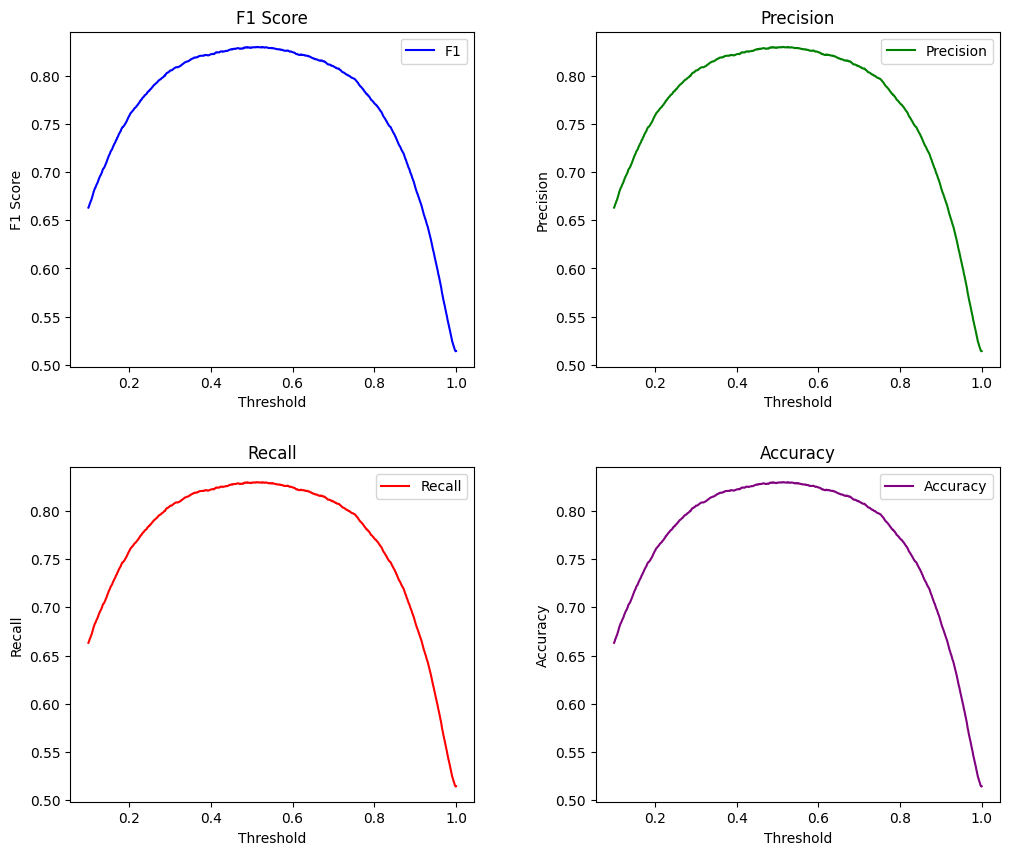

Logistic Regression Model best F1 score 0.486 at prob decision threshold >= 0.100


In [53]:
from sklearn.metrics import precision_score, recall_score

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = LR.predict_proba(X_val)[:,1] 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1_scores.append(f1_score(y_val, model_val_labels, average='micro'))

    acc_scores.append(accuracy_score(y_val, model_val_labels))
    

import matplotlib.pyplot as plt

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


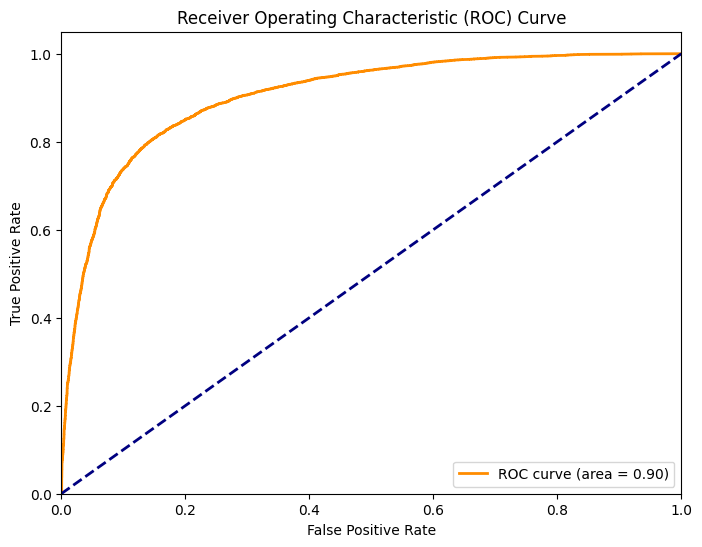

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [55]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.8781,   Recall: 0.7156


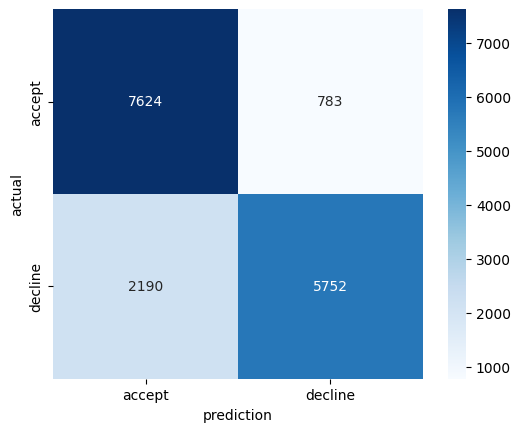

In [57]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

fraud_confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(fraud_confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

# KNeighborsClassifier

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Fill missing values with mean (or any other strategy) and scale the data
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_val = imputer.transform(X_val)
X_val = scaler.transform(X_val)

# Then, you can fit the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))


The accuracy for training :  0.9738644611104391
The accuracy for validation:  0.9530858156462169
F1_score for train:  0.9722349388397625
F1_score for validation:  0.9501138211382114


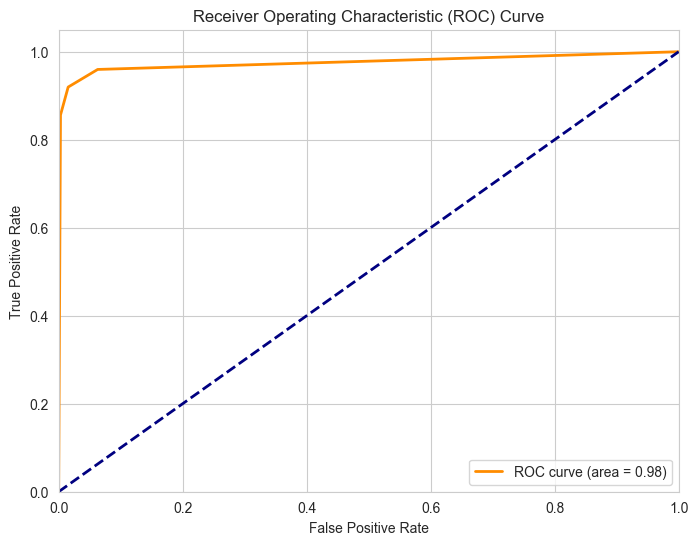

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [68]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.9931,   Recall: 0.9522


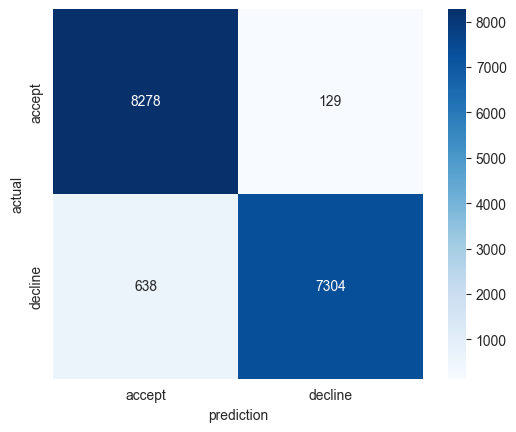

In [69]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

fraud_confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(fraud_confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

# Naive Bayes

In [70]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

The accuracy for training :  0.6057139833071247
The accuracy for validation:  0.6043183069300875
f1_score for train:  0.7090504376544622
f1_score for validation:  0.7105463331692693


# Ada Boost Classifier

In [71]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=0)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

The accuracy for training :  0.9953656102576509
The accuracy for validation:  0.9951679001773809
f1_score for train:  0.9951567154155506
f1_score for validation:  0.9950034785908544


# Stochastic Gradient Descent Algorithm

In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

The accuracy for training :  0.8306444296600943
The accuracy for validation:  0.8343017921585418
f1_score for train:  0.8166002145026731
f1_score for validation:  0.8235294117647058


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [ ]:
import xgboost as xgb  # Import the XGBoost library

import numpy as np


xgb_model = xgb.XGBClassifier()


parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': np.arange(0.1, 0.9, 0.1).tolist(),
    'max_depth': list(range(3, 10)),
    'min_child_weight': [11],
    'silent': [1],
    'subsample': np.arange(0.3, 1.0, 0.1).tolist(),  # Adjust the range here
    'colsample_bytree': [0.7],
    'n_estimators': list(range(7000, 10001, 500)),
    'missing': [-999],
    'seed': [1337]
}



clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=KFold(shuffle=True , random_state = 1), 
                   scoring='accuracy',
                   verbose=2, refit=True)

clf.fit(X_train,y_train)

Fitting 5 folds for each of 2744 candidates, totalling 13720 fits


In [ ]:
import pickle5 as pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
clf.best_params_

In [ ]:
gbm = xgb.XGBClassifier( 
                        n_estimators=7500,
           w             max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.6, 
                        subsample=.93,
                        min_child_weight=5,
                        colsample_bytree=.75
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

print(accuracy_score(y_train, gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)))
print(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))
print('f1_score for train: ',f1_score(gbm.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(gbm.predict(X_val), y_val))

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, gbm.predict_proba(X_train)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [ ]:
y_predict = (gbm.predict_proba(X_train)[:, 1] >= 0.59)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

# Pickle models

In [ ]:

lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=1)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=0)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [ ]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [ ]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [ ]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

# voting classifer (HARD)

In [ ]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

In [ ]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

In [ ]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

# Stacking Classifier

In [ ]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)

In [ ]:
stacked.fit(X_train, y_train)

In [ ]:
y_pred = stacked.predict(X_val)
accuracy_score(y_val, y_pred)

# Save model

In [ ]:
conda install -c conda-forge pickle5


In [ ]:
'''

with open('final_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
'''